In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import utils
from Sampling import Sampling
from VAE import VAE
from CAN import CAN

In [2]:
vae_epoch = 10000
vae_batch_size = 16
latent_dim = 10
beta_eeg = 5.0
test_split = 0.2
can_epoch = 10000
can_batch_size = 16
train = False

In [3]:
eeg, pupil = utils.read_single_trial_datasets()
eeg_train, eeg_test, pupil_train, pupil_test = train_test_split(
  eeg, pupil, test_size=0.2, random_state=42
)

In [4]:
# Load all encoders/decoders
vae = VAE(beta=beta_eeg, latent_dim=latent_dim)
vae.encoder = keras.models.load_model("vae_encoder")
vae.decoder = keras.models.load_model("vae_decoder")

In [21]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 8]

def plot_eeg_reconstruction(orig, rec, save=False, filename=''):
    orig, rec = np.squeeze(orig), np.squeeze(rec)
    orig = np.mean(orig, axis=0)
    rec = np.mean(rec, axis=0)
    #mm_rec = minmax_scale(rec, feature_range=(orig.min(),orig.max()))
    
    x = np.linspace(-500, 1000, num=len(orig)//2)
    plt.subplot(2, 1, 1)
    plt.plot(x, orig[:len(orig)//2], label='Original')
    plt.plot(x, rec[:len(rec)//2], label='Reconstruction')
    plt.legend(loc="upper left")
    plt.ylabel('Targets')

    plt.subplot(2, 1, 2)
    plt.plot(x, orig[len(orig)//2:], label='Original')
    plt.plot(x, rec[len(rec)//2:], label='Reconstruction')    
    plt.xlabel('Time (ms)')
    plt.ylabel('Distractors')
    plt.legend(loc="upper left")
    fig = plt.gcf()
    plt.show()
    
    err_t = np.sqrt(mean_squared_error(orig[:len(orig)//2], rec[:len(rec)//2]))
    err_d = np.sqrt(mean_squared_error(orig[len(orig)//2:], rec[len(rec)//2:]))
    t_err = str(err_t)    
    d_err = str(err_d)
    idx_t = t_err.find('.')
    idx_d = d_err.find('.')
    t_err = t_err[idx_t+1:idx_t+5]
    d_err = d_err[idx_d+1:idx_d+5]
    
    if save:
        fig.savefig(filename + '_t' + str(t_err) + '_d' + str(d_err) + '.png')
        
    print('RMSE Targets: ' + str(err_t))
    print('RMSE Distractors: ' + str(err_d))

In [22]:
eeg_encode = vae.encoder.predict(eeg_test)
ee_rec = vae.decoder.predict(eeg_encode)

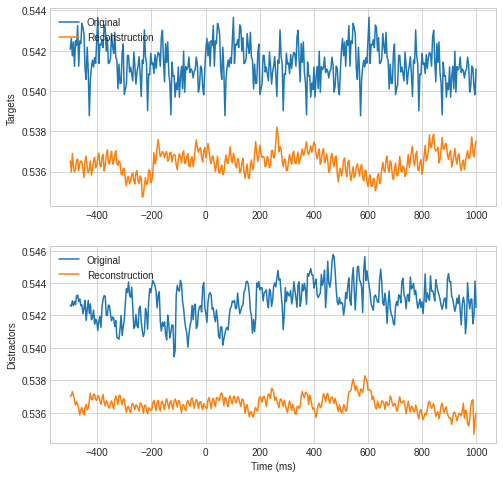

RMSE Targets: 0.0050391187
RMSE Distractors: 0.006394434


In [98]:
i = 218
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_test[i], ee_rec[i], save=True, filename=fn)